In [1]:
from abc import abstractmethod, ABC

import torch
import gpytorch
from torchdiffeq import odeint
import numpy as np
from matplotlib import pyplot as plt

from alfi.configuration import VariationalConfiguration
from alfi.utilities.torch import is_cuda
from alfi.models.lfm import LFM
from alfi.mlls import MaskedVariationalELBO
from alfi.plot import Plotter1d, plot_phase, Colours
from alfi.utilities.torch import softplus, inv_softplus

from torch.nn.parameter import Parameter


from gpytorch.models import ApproximateGP
from gpytorch.likelihoods import MultitaskGaussianLikelihood
from gpytorch.constraints import Positive, Interval

from src.data_loader import PVDataLoader
from src import data_loader as dl
from lfm.dataset import PV_LFM_Dataset


In [2]:
# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# data parameters
DAY_INIT = 0
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 2
N_SYSTEMS = 15
RADIUS = 0.35
COORDS = (55, -1.5)
IDX = 6
NUM_OUTPUTS = 1
NUM_LATENTS = 1
NUM_INDUCING = 100

In [3]:
loader = PVDataLoader(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')

time, y = loader.get_time_series()

periodic_time = dl.periodic_mapping(time, DAY_MIN, DAY_MAX, minute_interval=MINUTE_INTERVAL)
periodic_train, _, periodic_test, _ = dl.train_test_split(periodic_time, y, n_hours=N_HOURS_PRED)

time = torch.linspace(0, 15, len(y))

t_train, y_train, t_test, y_test = dl.train_test_split(time, y, n_hours=N_HOURS_PRED)

periodic_train *= y_train[:,:NUM_OUTPUTS].max()
periodic_test *= y_test[:,:NUM_OUTPUTS].max()

==> Loading data
==> Loaded data in: 0 m : 8 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [16]:
dataset = PV_LFM_Dataset(num_outputs=NUM_OUTPUTS, 
                         m_observed=y_train[:, :NUM_OUTPUTS],
                         f_observed=periodic_train, 
                         train_t=t_train,
                         variance= 0.01 * torch.ones(NUM_OUTPUTS, dtype=torch.float64))

In [17]:
x_min, x_max = dataset.t_observed.min(), dataset.t_observed.max()
num_training = len(dataset.t_observed)

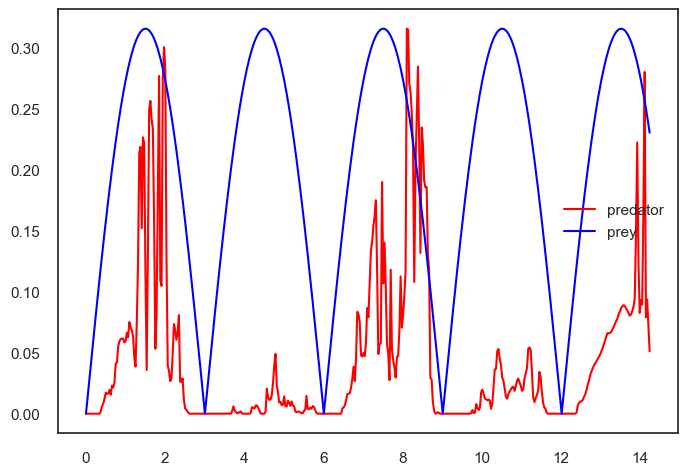

In [6]:
plt.plot(dataset.data[0][0], dataset.data[0][1], c='red', label='predator')
plt.plot(torch.linspace(x_min, x_max, dataset.f_observed.shape[-1]), dataset.f_observed[0,0,:], c='blue', label='prey')
plt.legend()
output_names = dataset.names

In [8]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import (
    NaturalVariationalDistribution,
    CholeskyVariationalDistribution,
    VariationalStrategy,
    IndependentMultitaskVariationalStrategy,
    TrilNaturalVariationalDistribution
)

class MultiOutputGP(ApproximateGP):
    def __init__(self,
                 mean_module,
                 covar_module,
                 inducing_points,
                 num_latents,
                 learn_inducing_locations=False,
                 natural=True,
                 use_tril=False):
        # The variational dist batch shape means we learn a different variational dist for each latent
        if natural:
            Distribution = TrilNaturalVariationalDistribution if use_tril else NaturalVariationalDistribution
            variational_distribution = Distribution(
                inducing_points.size(-2), batch_shape=torch.Size([num_latents])
            )
        else:
            variational_distribution = CholeskyVariationalDistribution(
                inducing_points.size(-2), batch_shape=torch.Size([num_latents])
            )

        # Wrap the VariationalStrategy in a MultiTask to make output MultitaskMultivariateNormal
        # rather than a batch MVN
        variational_strategy = IndependentMultitaskVariationalStrategy(
            VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=learn_inducing_locations
            ), num_tasks=num_latents
        )
        super().__init__(variational_strategy)

        self.mean_module = mean_module
        self.covar_module = covar_module

    def get_inducing_points(self):
        return self.variational_strategy.base_variational_strategy.inducing_points

    def forward(self, t):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(t)
        covar_x = self.covar_module(t)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def generate_multioutput_rbf_gp(num_latents, inducing_points,
                                ard_dims=None,
                                use_scale=False,
                                initial_lengthscale=None,
                                lengthscale_constraint=None,
                                zero_mean=True,
                                gp_kwargs={}):
    # Modules should be marked as batch so different set of hyperparameters are learnt
    if zero_mean:
        mean_module = gpytorch.means.ZeroMean(batch_shape=torch.Size([num_latents]))
    else:
        mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
    covar_module = gpytorch.kernels.RBFKernel(
        batch_shape=torch.Size([num_latents]),
        ard_num_dims=ard_dims,
        lengthscale_constraint=lengthscale_constraint
    )
    if use_scale:
        covar_module = gpytorch.kernels.ScaleKernel(
            covar_module,
            batch_shape=torch.Size([num_latents])
        )
    if initial_lengthscale is not None:
        if use_scale:
            covar_module.base_kernel.lengthscale = initial_lengthscale
        else:
            covar_module.lengthscale = initial_lengthscale
    return MultiOutputGP(mean_module, covar_module, inducing_points, num_latents, **gp_kwargs)

In [9]:
class VariationalLFM(LFM, ABC):
    """
    Variational inducing point approximation for Latent Force Models.

    Parameters
    ----------
    num_outputs : int : the number of outputs (for example, the number of genes)
    fixed_variance : tensor : variance if the preprocessing variance is known, otherwise learnt.
    """
    def __init__(self,
                 num_outputs: int,
                 gp_model: ApproximateGP,
                 config: VariationalConfiguration,
                 num_training_points=None,
                 dtype=torch.float64):
        super().__init__()
        self.gp_model = gp_model
        self.num_outputs = num_outputs
        self.likelihood = MultitaskGaussianLikelihood(num_tasks=self.num_outputs)
        self.pretrain_mode = False
        try:
            self.inducing_points = self.gp_model.get_inducing_points()
        except AttributeError:
            raise AttributeError('The GP model must define a function `get_inducing_points`.')

        if num_training_points is None:
            num_training_points = self.inducing_points.numel()  # TODO num_data refers to the number of training datapoints

        self.loss_fn = MaskedVariationalELBO(self.likelihood, gp_model, num_training_points, combine_terms=False)
        self.config = config
        self.dtype = dtype

        # if config.preprocessing_variance is not None:
        #     self.likelihood_variance = Parameter(torch.tensor(config.preprocessing_variance), requires_grad=False)
        # else:
        #     self.raw_likelihood_variance = Parameter(torch.ones((self.num_outputs, self.num_observed), dtype=dtype))

        if config.initial_conditions:
            self.initial_conditions = Parameter(torch.tensor(torch.zeros(self.num_outputs, 1)), requires_grad=True)

    def nonvariational_parameters(self):
        variational_keys = dict(self.gp_model.named_variational_parameters()).keys()
        named_parameters = dict(self.named_parameters())
        return [named_parameters[key] for key in named_parameters.keys()
                if key[len('gp_model.'):] not in variational_keys]

    def variational_parameters(self):
        return self.gp_model.variational_parameters()

    def summarise_gp_hyp(self):
        # variational_keys = dict(self.gp_model.named_variational_parameters()).keys()
        # named_parameters = dict(self.named_parameters())
        #
        # return [named_parameters[key] for key in named_parameters.keys()
        #         if key[len('gp_model.'):] not in variational_keys]
        if self.gp_model.covar_module.lengthscale is not None:
            return self.gp_model.covar_module.lengthscale.detach().cpu().numpy()
        elif hasattr(self.gp_model.covar_module, 'base_kernel'):
            kernel = self.gp_model.covar_module.base_kernel
            if hasattr(kernel, 'kernels'):
                if hasattr(kernel.kernels[0], 'lengthscale'):
                    return kernel.kernels[0].lengthscale.detach().cpu().numpy()
            else:
                return self.gp_model.covar_module.base_kernel.lengthscale.detach().cpu().numpy()
        else:
            return ''

    def forward(self, x):
        raise NotImplementedError

    def train(self, mode: bool = True):
        self.gp_model.train(mode)
        self.likelihood.train(mode)

    def pretrain(self, mode=True):
        self.pretrain_mode = mode

    def eval(self):
        self.gp_model.eval()
        self.likelihood.eval()
        self.pretrain(False)

    def predict_m(self, t_predict, **kwargs) -> torch.distributions.MultivariateNormal:
        """
        Calls self on input `t_predict`
        """
        return self(t_predict.view(-1), **kwargs)

    def predict_f(self, t_predict, **kwargs) -> torch.distributions.MultivariateNormal:
        """
        Returns the latents
        """
        self.eval()
        with torch.no_grad():
            q_f = self.gp_model(t_predict)
        self.train()
        return q_f

    def save(self, filepath):
        torch.save(self.gp_model.state_dict(), str(filepath)+'gp.pt')
        torch.save(self.state_dict(), str(filepath)+'lfm.pt')

    @classmethod
    def load(cls,
             filepath,
             gp_cls=None, gp_model=None,
             gp_args=[], gp_kwargs={},
             lfm_args=[], lfm_kwargs={}):
        assert not (gp_cls is None and (gp_model is None))
        gp_state_dict = torch.load(filepath+'gp.pt')
        if gp_cls is not None:
            gp_model = gp_cls(*gp_args, **gp_kwargs)
        gp_model.load_state_dict(gp_state_dict)
        gp_model.double()

        lfm_state_dict = torch.load(filepath+'lfm.pt')
        lfm = cls(lfm_args[0], gp_model, *lfm_args[1:], **lfm_kwargs)
        lfm.load_state_dict(lfm_state_dict)
        return lfm

In [10]:
class OrdinaryLFM(VariationalLFM):
    """
    Variational approximation for an LFM based on an ordinary differential equation (ODE).
    Inheriting classes must override the `odefunc` function which encodes the ODE.
    """

    def __init__(self, num_outputs, gp_model, config: VariationalConfiguration, **kwargs):
        super().__init__(num_outputs, gp_model, config, **kwargs)
        self.nfe = 0
        self.f = None

    def initial_state(self):
        initial_state = torch.zeros(torch.Size([self.num_outputs, 1]), dtype=torch.float64)
        initial_state = initial_state.cuda() if is_cuda() else initial_state
        return initial_state #initial_state.repeat(self.config.num_samples, 1, 1)  # Add batch dimension for sampling
        # if self.config.initial_conditions: TODO:
        #     h = self.initial_conditions.repeat(h.shape[0], 1, 1)

    def forward(self, t, step_size=1e-1, return_samples=False, **kwargs):
        """
        t : torch.Tensor
            Shape (num_times)
        h : torch.Tensor the initial state of the ODE
            Shape (num_genes, 1)
        Returns
        -------
        Returns evolved h across times t.
        Shape (num_genes, num_points).
        """
        self.nfe = 0

        # Get GP outputs
        if self.pretrain_mode:
            t_f = t[0]
            h0 = t[1]
        else:
            t_f = torch.arange(t.min(), t.max()+ 2*step_size/3, step_size/3)
            h0 = self.initial_state()
            h0 = h0.unsqueeze(0).repeat(self.config.num_samples, 1, 1)

        q_f = self.gp_model(t_f)

        self.f = q_f.rsample(torch.Size([self.config.num_samples])).permute(0, 2, 1)  # (S, I, T)
        self.f = self.G(self.f)

        if self.pretrain_mode:
            h_samples = self.odefunc(t_f, h0)
            h_samples = h_samples.permute(2, 0, 1)
        else:
            # Integrate forward from the initial positions h0.
            self.t_index = 0
            self.last_t = self.f.min() - 1
            h_samples = odeint(self.odefunc, h0, t, method='rk4', options=dict(step_size=step_size)) # (T, S, num_outputs, 1)

        self.f = None
        # self.t_index = None
        # self.last_t = None
        if return_samples:
            return h_samples

        h_mean = torch.mean(h_samples, dim=1).squeeze(-1).transpose(0, 1)  # shape was (#outputs, #T, 1)
        h_var = torch.var(h_samples, dim=1).squeeze(-1).transpose(0, 1) + 1e-7
        h_mean = self.decode(h_mean)
        h_var = self.decode(h_var)
        # TODO: make distribution something less constraining
        h_covar = torch.diag_embed(h_var) + torch.eye(self.num_outputs, dtype=torch.float64) * 1e-1
        batch_mvn = gpytorch.distributions.MultivariateNormal(h_mean, h_covar)
        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(batch_mvn, task_dim=0)

    def decode(self, h_out):
        return h_out

    @abstractmethod
    def odefunc(self, t, h):
        """
        Parameters:
            h: shape (num_samples, num_outputs, 1)
        """
        pass

    def G(self, f):
        return f.repeat(1, self.num_outputs, 1)  # (S, I, t)

In [58]:
class LotkaVolterra(OrdinaryLFM):
    """Outputs are predator. Latents are prey"""
    def __init__(self, num_outputs, gp_model, config: VariationalConfiguration, **kwargs):
        super().__init__(num_outputs, gp_model, config, **kwargs)
        self.num_tasks = num_outputs
        self.positivity = Positive()
        self.decay_constraint = Interval(0., 100.)
        self.raw_decay = Parameter(self.decay_constraint.inverse_transform(torch.ones(torch.Size([self.num_outputs, 1]), dtype=torch.float64)))
        self.raw_growth = Parameter(self.positivity.inverse_transform(0.5*torch.ones(torch.Size([self.num_outputs, 1]), dtype=torch.float64)))
        self.raw_initial = Parameter(self.positivity.inverse_transform(0.3+torch.zeros(torch.Size([self.num_outputs, 1]), dtype=torch.float64)))

    @property
    def decay_rate(self):
        return self.decay_constraint.transform(self.raw_decay)

    @decay_rate.setter
    def decay_rate(self, value):
        self.raw_decay = self.decay_constraint.inverse_transform(value)

    @property
    def growth_rate(self):
        return softplus(self.raw_growth)

    @growth_rate.setter
    def growth_rate(self, value):
        self.raw_growth = inv_softplus(value)

    @property
    def initial_predators(self):
        return softplus(self.raw_initial)

    @initial_predators.setter
    def initial_predators(self, value):
        self.raw_initial = inv_softplus(value)

    def initial_state(self):
        return self.initial_predators

    def odefunc(self, t, h):
        """h is of shape (num_samples, num_outputs, 1)"""
        self.nfe += 1
        f = self.G(self.f[:, :, self.t_index].unsqueeze(2))
        dh = self.growth_rate * h * f - self.decay_rate * h
        
        if t > self.last_t:
            self.t_index += 1
        self.last_t = t
        return dh

    def G(self, f):
        # I = 1 so just repeat for num_outputs
        #softplus
        return softplus(f).repeat(1, self.num_outputs, 1)

/var/folders/3f/5b_39xqs2tlgzd30m4ll014r0000gn/T/ipykernel_85016/4166399231.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.initial_conditions = Parameter(torch.tensor(torch.zeros(self.num_outputs, 1)), requires_grad=True)
/Users/eirikbaekkelund/opt/anaconda3/envs/gp/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/eirikbaekkelund/opt/anaconda3/envs/gp/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/eirikbaekkelund/opt/anaconda3/envs/gp/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/eirikbaekke

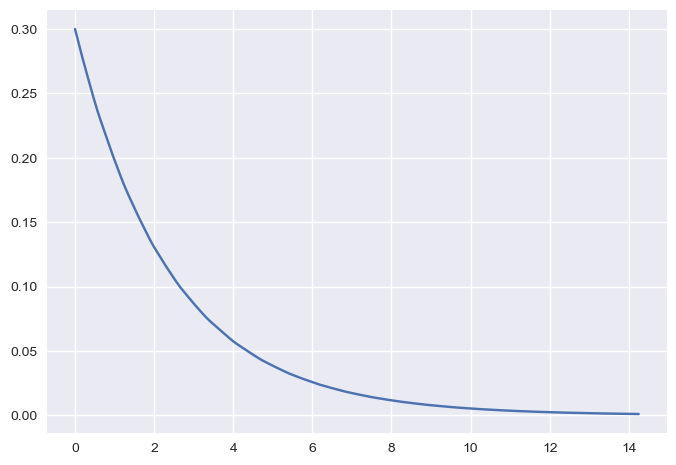

In [59]:
use_natural = False
config = VariationalConfiguration(num_samples=70)
inducing_points = torch.linspace(x_min, x_max, NUM_INDUCING).repeat(NUM_LATENTS, 1).view(
    NUM_LATENTS, NUM_INDUCING, 1)
t_predict = torch.linspace(0, x_max, 151, dtype=torch.float32)

# TODO change kernel

periodic = True
mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([NUM_LATENTS]))

track_parameters = ['raw_growth', 'raw_decay']

covar_module = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(batch_shape=torch.Size([NUM_LATENTS])),
    batch_shape=torch.Size([NUM_LATENTS])
) 
covar_module.base_kernel.lengthscale = 0.1
# covar_module.base_kernel.period_length = 0.5
track_parameters.append('gp_model.covar_module.base_kernel.raw_lengthscale')


gp_model = MultiOutputGP(mean_module, covar_module,
                         inducing_points, NUM_LATENTS,
                         natural=use_natural)


lfm = LotkaVolterra(NUM_OUTPUTS, gp_model, config, num_training_points=num_training)

plotter = Plotter1d(lfm, np.array(['predator']))

out = lfm(t_predict, step_size=1e-1)
plt.plot(t_predict, out.mean.detach())

In [60]:
from alfi.trainers import VariationalTrainer
optimizers = [torch.optim.Adam(lfm.parameters(), lr=0.02)]

trainer = VariationalTrainer(
    lfm,
    optimizers,
    dataset,
    warm_variational=50,
    track_parameters=track_parameters
)

In [61]:
trainer.train(200, report_interval=10, step_size=3)


Epoch 001/200 - Loss: 1.12 0.00kernel: [[[0.10192029]]]
Epoch 011/200 - Loss: 1.05 0.00kernel: [[[0.11671459]]]
Epoch 021/200 - Loss: 0.98 0.00kernel: [[[0.12288711]]]
Epoch 031/200 - Loss: 0.91 0.00kernel: [[[0.1260523]]]
Epoch 041/200 - Loss: 0.84 0.00kernel: [[[0.13378195]]]
Epoch 051/200 - Loss: 0.77 0.00kernel: [[[0.14156994]]]
Epoch 061/200 - Loss: 0.69 0.00kernel: [[[0.14954045]]]
Epoch 071/200 - Loss: 0.62 0.00kernel: [[[0.15179476]]]
Epoch 081/200 - Loss: 0.56 0.00kernel: [[[0.14161254]]]
Epoch 091/200 - Loss: 0.50 0.00kernel: [[[0.12112428]]]
Epoch 101/200 - Loss: 0.44 0.00kernel: [[[0.10340029]]]
Epoch 111/200 - Loss: 0.40 0.00kernel: [[[0.08601103]]]
Epoch 121/200 - Loss: 0.36 0.00kernel: [[[0.06942531]]]
Epoch 131/200 - Loss: 0.33 0.00kernel: [[[0.05575277]]]
Epoch 141/200 - Loss: 0.31 0.00kernel: [[[0.0465782]]]
Epoch 151/200 - Loss: 0.30 0.00kernel: [[[0.0397631]]]
Epoch 161/200 - Loss: 0.29 0.00kernel: [[[0.03557762]]]
Epoch 171/200 - Loss: 0.29 0.00kernel: [[[0.0331562

[(1689689282.493181,
  (1.122072512349479, (1.1220724119627081, 1.0038677089596604e-07))),
 (1689689282.624487,
  (1.1159005675186937, (1.1152884591907797, 0.0006121083279140294))),
 (1689689282.7621582,
  (1.109056429992582, (1.1084046521542252, 0.0006517778383567929))),
 (1689689282.88353,
  (1.1019511617754485, (1.1016668246278438, 0.0002843371476046741))),
 (1689689283.007861,
  (1.0955334609275995, (1.0949119162647365, 0.0006215446628630161))),
 (1689689283.131941,
  (1.0886713927263953, (1.0880931147492119, 0.0005782779771834612))),
 (1689689283.255212,
  (1.0815011216681705, (1.0812884021060563, 0.0002127195621142164))),
 (1689689283.376267,
  (1.0743967042632463, (1.074311977832305, 8.472643094137311e-05))),
 (1689689283.498179,
  (1.0677441926705926, (1.0674817063587527, 0.00026248631183989346))),
 (1689689283.627139,
  (1.0609752948607536, (1.0605980413770055, 0.00037725348374806345))),
 (1689689283.7523289,
  (1.0539531233368347, (1.0536911055093536, 0.0002620178274810314)))

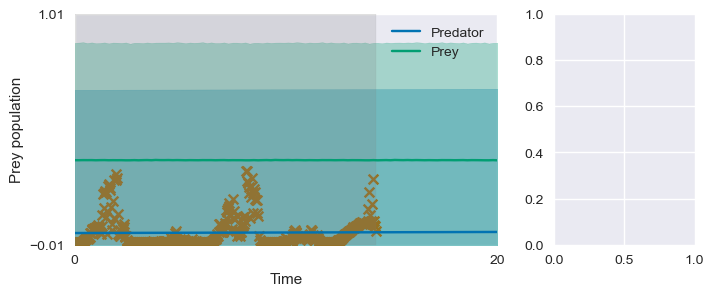

In [62]:
lfm.eval()
t_interval = (0, 20)
t_predict = torch.linspace(*t_interval, 100, dtype=torch.float32)
t_scatter = dataset.data[0][0].unsqueeze(0).unsqueeze(0)
y_scatter = dataset.data[0][1].unsqueeze(0).unsqueeze(0)

q_m = lfm.predict_m(t_predict, step_size=5e-1)
q_f = lfm.predict_f(t_predict)
ylim = (-0.01, 1.01)
fig, axes = plt.subplots(ncols=2,
                         figsize=(8, 3),
                         gridspec_kw=dict(width_ratios=[3, 1]))
plotter.plot_gp(q_m, t_predict, num_samples=0,
                t_scatter=t_scatter,
                y_scatter=y_scatter,
                ylim=ylim,
                titles=None, ax=axes[0])
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Population')
axes[0].set_xlim(*t_interval)
# axes[0].legend()

plotter.plot_gp(q_f, t_predict,
                transform=softplus,
                color=Colours.line2_color,
                shade_color=Colours.shade2_color,
                ylim=ylim,
                titles=None, ax=axes[0])

axes[0].set_xlabel('Time')
axes[0].set_ylabel('Prey population')
axes[0].set_xticks([t_predict[0], t_predict[-1]])
# axes[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2, integer=True))
axes[0].set_yticks([ylim[0], ylim[1]])
axes[0].fill_between(t_scatter.squeeze(), ylim[0], ylim[1], alpha=0.2, color='gray')
axes[0].get_lines()[0].set_label('Predator')
axes[0].get_lines()[1].set_label('Prey')
axes[0].legend()
